# Hyperparameter Tuning

In [05_first_neural_net.ipynb](05_first_neural_net.ipynb) we constructed the network and got to the point where we are ready to try and tune our hyperparameters.

## Network Setup

In [4]:
import numpy as np
import pandas as pd
import re
import torch
import torch.nn.functional as F
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

# load data
df = pd.read_csv("cleaned_data/clean_2.csv", keep_default_na=False)

# setup vocabulary
PADDING_TOKEN_INDEX = 0
PAD_TO_SIZE = 50

def yield_tokens(data_iter):
    for text in data_iter:
        yield tokenizer(text)
        
tokenizer = get_tokenizer('basic_english')
answers_vocab = build_vocab_from_iterator(yield_tokens(df['answer'].values), specials=["<pad>"])
clues_vocab = build_vocab_from_iterator(yield_tokens(df['clue'].values), specials=["<pad>"])
clue_pipeline = lambda x: clues_vocab(tokenizer(x))

# create splits
def build_dataset(split):
    splits = {
        'train': train,
        'dev': dev,
        'test': test
    }
    df = splits[split]
    answers_stoi = answers_vocab.get_stoi()
    
    X = []
    Y = []

    for clue in df['clue'].values:
        indicies = clue_pipeline(clue)
        indicies += [PADDING_TOKEN_INDEX] * (PAD_TO_SIZE - len(indicies))
        X.append(indicies)

    for answer in df['answer'].values:
        answer_index = answers_stoi[answer]
        Y.append(answer_index)
        
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return (X, Y)

train, dev, test = np.split(df.sample(frac=1, random_state=42), [int(.8*len(df)), int(.9*len(df))])
Xdev, Ydev = build_dataset('dev')
Xtest, Ytest = build_dataset('test')
Xtr, Ytr = build_dataset('train')

## Training
Let's start with the same parameters as we had last time and see what that gets us.

In [9]:
# hyperparameters
EMBEDDING_DIMENSIONS = 25
HIDDEN_NEURON_COUNT = 200
BATCH_SIZE = 64
LEARNING_RATE = 0.1

# build network
g = torch.Generator().manual_seed(42)
C = torch.randn((len(clues_vocab), EMBEDDING_DIMENSIONS))
W1 = torch.randn(PAD_TO_SIZE * EMBEDDING_DIMENSIONS, HIDDEN_NEURON_COUNT)
b1 = torch.randn(HIDDEN_NEURON_COUNT)
W2 = torch.randn((HIDDEN_NEURON_COUNT, len(answers_vocab)))
b2 = torch.randn(len(answers_vocab))
parameters = [C, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True
    
def train(iterations):
    for i in range(iterations):
        # minibatch
        ix = torch.randint(0, Xtr.shape[0], (BATCH_SIZE,))

        # forward pass
        emb = C[Xtr[ix]] # (BATCH_SIZE, PAD_TO_SIZE, EMBEDDING_DIMENSIONS)
        concat = emb.view(-1, PAD_TO_SIZE * EMBEDDING_DIMENSIONS) # (BATCH_SIZE, PAD_TO_SIZE * EMBEDDING_DIMENSIONS)
        h = torch.tanh(concat @ W1 + b1) # (BATCH_SIZE, HIDDEN_NEURON_COUNT)
        logits = h @ W2 + b2 # (BATCH_SIZE, len(answers_vocab))
        loss = F.cross_entropy(logits, Ytr[ix])
        if i == 0:
            print('Initial loss:', loss.item())

        # backward pass
        for p in parameters:
            p.grad = None
        loss.backward()

        # update
        for p in parameters:
            p.data += -LEARNING_RATE * p.grad

    print('Final loss:', loss.item())

def evaluate():
    emb = C[Xdev] # (BATCH_SIZE, PAD_TO_SIZE, EMBEDDING_DIMENSIONS)
    concat = emb.view(-1, PAD_TO_SIZE * EMBEDDING_DIMENSIONS) # (BATCH_SIZE, PAD_TO_SIZE * EMBEDDING_DIMENSIONS)
    h = torch.tanh(concat @ W1 + b1) # (BATCH_SIZE, HIDDEN_NEURON_COUNT)
    logits = h @ W2 + b2 # (BATCH_SIZE, len(answers_vocab))
    loss = F.cross_entropy(logits, Ydev)
    return loss.item()

In [10]:
%%time
train(1000)

Initial loss: 61.324180603027344
Final loss: 28.210540771484375
CPU times: user 1min 31s, sys: 13.2 s, total: 1min 45s
Wall time: 26 s


In [11]:
%%time
loss = evaluate()
print('Dev loss:', loss)

Dev loss: <built-in method item of Tensor object at 0x104682c20>
CPU times: user 19.9 s, sys: 34 s, total: 53.9 s
Wall time: 36.8 s


The model definitely seems to be training, but we want to optimize this. Let's first try different learning rates and figure out what seems to work best.

The first thing we can try is changing the learning rate as we train.

## Learning Rate Optimization

In [68]:
# hyperparameters
EMBEDDING_DIMENSIONS = 25
HIDDEN_NEURON_COUNT = 200
BATCH_SIZE = 64

class Model:
    
    def __init__(self):
        # build network
        self.g = torch.Generator().manual_seed(42)
        self.C = torch.randn((len(clues_vocab), EMBEDDING_DIMENSIONS))
        self.W1 = torch.randn(PAD_TO_SIZE * EMBEDDING_DIMENSIONS, HIDDEN_NEURON_COUNT)
        self.b1 = torch.randn(HIDDEN_NEURON_COUNT)
        self.W2 = torch.randn((HIDDEN_NEURON_COUNT, len(answers_vocab)))
        self.b2 = torch.randn(len(answers_vocab))
        self.parameters = [self.C, self.W1, self.b1, self.W2, self.b2]
        for p in self.parameters:
            p.requires_grad = True
    
    # train for a number of iterations and use the corresponding lr from lrs for each iteration
    # return stats of the loss for each iteration
    def train(self, lrs):
        lossi = []
        lri = []
        stepi = []
        for i in range(len(lrs)):
            # minibatch
            ix = torch.randint(0, Xtr.shape[0], (BATCH_SIZE,), generator=self.g)

            # forward pass
            emb = self.C[Xtr[ix]] # (BATCH_SIZE, PAD_TO_SIZE, EMBEDDING_DIMENSIONS)
            concat = emb.view(-1, PAD_TO_SIZE * EMBEDDING_DIMENSIONS) # (BATCH_SIZE, PAD_TO_SIZE * EMBEDDING_DIMENSIONS)
            h = torch.tanh(concat @ self.W1 + self.b1) # (BATCH_SIZE, HIDDEN_NEURON_COUNT)
            logits = h @ self.W2 + self.b2 # (BATCH_SIZE, len(answers_vocab))
            loss = F.cross_entropy(logits, Ytr[ix])
            if i == 0:
                print('Initial loss:', loss.item())

            # backward pass
            for p in self.parameters:
                p.grad = None
            loss.backward()

            # update
            for p in self.parameters:
                p.data += -lrs[i] * p.grad

            # track stats
            stepi.append(i)
            lri.append(lrs[i])
            lossi.append(loss.item())

        print('Final loss:', loss.item())

        return stepi, lri, lossi

    def evaluate(self):
        emb = self.C[Xdev] # (BATCH_SIZE, PAD_TO_SIZE, EMBEDDING_DIMENSIONS)
        concat = emb.view(-1, PAD_TO_SIZE * EMBEDDING_DIMENSIONS) # (BATCH_SIZE, PAD_TO_SIZE * EMBEDDING_DIMENSIONS)
        h = torch.tanh(concat @ self.W1 + self.b1) # (BATCH_SIZE, HIDDEN_NEURON_COUNT)
        logits = h @ self.W2 + self.b2 # (BATCH_SIZE, len(answers_vocab))
        loss = F.cross_entropy(logits, Ydev)
        return loss.item()

In [69]:
# let's take learning rates from 0.0001 to 100 (10^-4, 10^2)
lre = torch.linspace(-4, 2, 1000)
lrs = 10**lre

model = Model()

stepi, lri, lossi = model.train(lrs)

Initial loss: 60.29440689086914
Final loss: 1149.73388671875


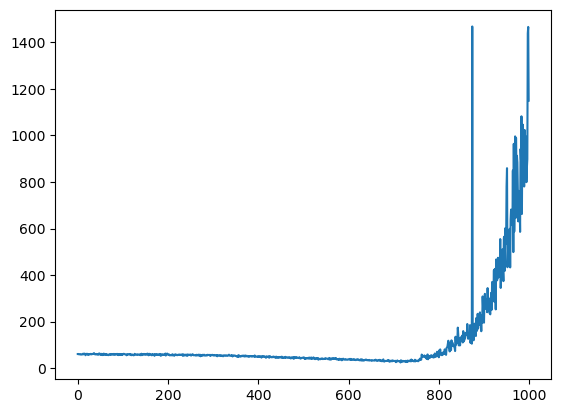

In [70]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(stepi, lossi)

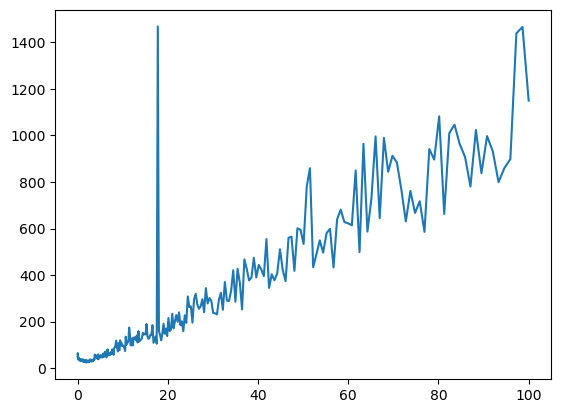

In [71]:
plt.plot(lri, lossi)

Are learning rates are way too high, let's try again with some more reasonable values.

In [72]:
# let's take learning rates from 0.00001 to 10 (10^-5, 10^1)
lre = torch.linspace(-5, 1, 1000)
lrs = 10**lre

model = Model()

stepi, lri, lossi = model.train(lrs)

Initial loss: 56.968711853027344
Final loss: 103.90625


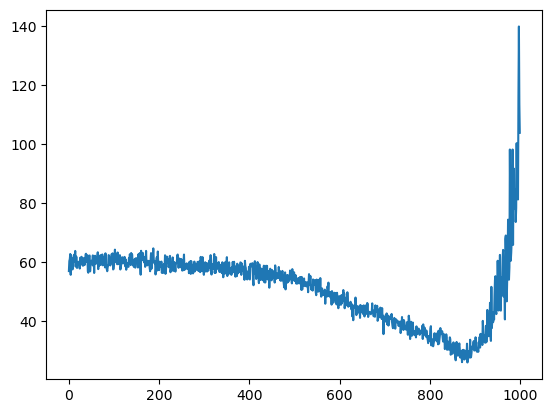

In [73]:
plt.plot(stepi, lossi)

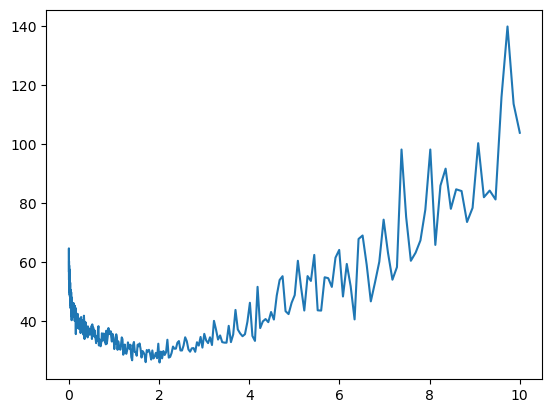

In [74]:
plt.plot(lri, lossi)

That's better, but lets zoom in more on the low range.

In [75]:
# let's take learning rates from 0.000001 to 1 (10^-6, 10^0)
lre = torch.linspace(-6, 0, 10000)
lrs = 10**lre

model = Model()

stepi, lri, lossi = model.train(lrs)

Initial loss: 62.19324493408203
Final loss: 19.680482864379883


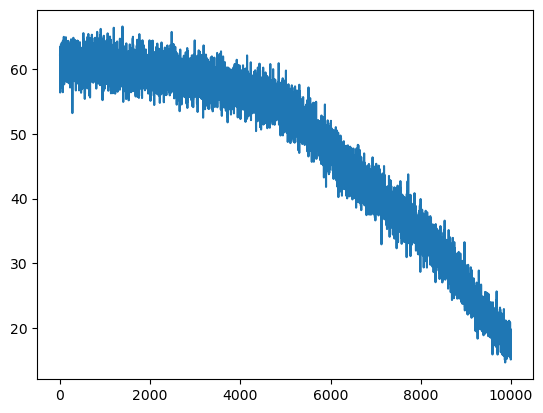

In [77]:
plt.plot(stepi, lossi)

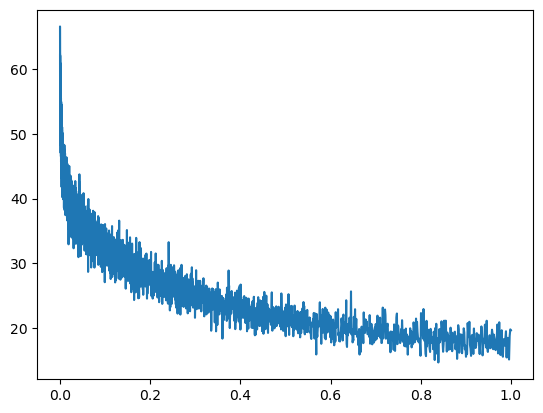

In [78]:
plt.plot(lri, lossi)

That's pretty noisy, let's smooth out the curve

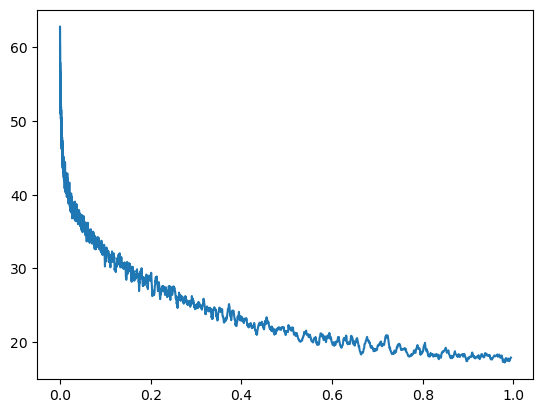

In [89]:
padding = np.ones(4) * np.nan
padded_arr = np.concatenate([padding, lossi, padding])
rolling_mean = np.convolve(padded_arr, np.ones(9)/9, mode='valid')

plt.plot(lri, rolling_mean)

We're getting closer, but it's still hard to tell - let's try again with values between 0 and 0.2

In [99]:
# let's take learning rates from 0.000001 to 1 (10^-6, 10^-1.69)
lre = torch.linspace(-6, -1.69, 10000)
lrs = 10**lre

model = Model()

stepi, lri, lossi = model.train(lrs)

Initial loss: 58.140377044677734
Final loss: 38.116607666015625


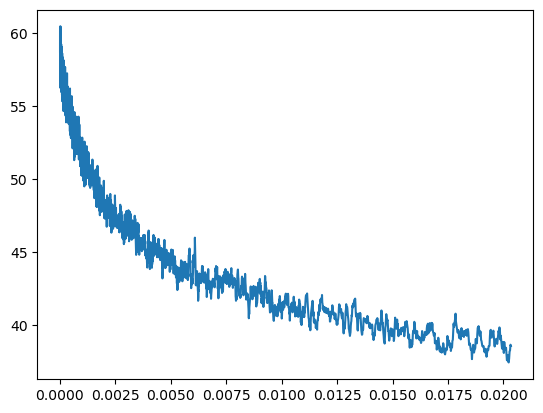

In [100]:
padding = np.ones(4) * np.nan
padded_arr = np.concatenate([padding, lossi, padding])
rolling_mean = np.convolve(padded_arr, np.ones(9)/9, mode='valid')

plt.plot(lri, rolling_mean)

That is better, but let's try again with the model partially trained

In [101]:
stepi, lri, lossi = model.train(lrs)

Initial loss: 37.76738357543945
Final loss: 34.71855545043945


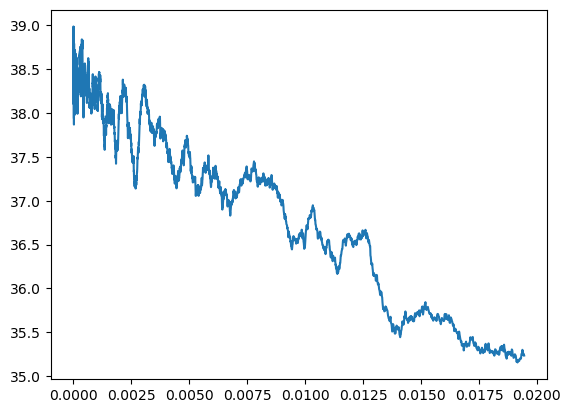

In [110]:
padding = np.ones(49) * np.nan
padded_arr = np.concatenate([padding, lossi, padding])
rolling_mean = np.convolve(padded_arr, np.ones(99)/99, mode='valid')

plt.plot(lri, rolling_mean)

This isn't as clean as I'd expect, but let's just roll with 0.125. We will be adjusting the shape of the network so all of this is likely not that informative.

## Batches and Epochs

Batches are the number of samples to work through before updaing the internal model parameters. Currently we're using minibatch gradient decent.

Epochs are the number of times we go through the dataset.

## Size of Embedding Layer

I found a [decent sounding rule of thumb](https://ai.stackexchange.com/questions/28564/how-to-determine-the-embedding-size) online stating that the number of embeddings should be:
```
num_embeddings = 75.6496 * ln(num_categories + 176.623) - 41.4457
```

In [118]:
num_categories = len(answers_vocab)
num_embeddings = 75.6496 * np.log(num_categories + 176.623) - 41.4457
num_embeddings

794.705198297013

According to a [Google post](https://developers.googleblog.com/2017/11/introducing-tensorflow-feature-columns.html) the number of dimensions should be:
```
embedding_dimensions =  number_of_categories**0.25
```

In [120]:
num_categories = len(answers_vocab)
num_embeddings = num_categories**0.25
num_embeddings

15.83996099271095

That seems reasonable, let's just roll with that for now 🤷‍♂️

## Number of neurons
I found some rule-of-thumb methods for determinging the correct number of neurons to use in the hidden layer:
* The number of hidden neurons should be between the size of the input layer and the size of the output layer.
* The number of hidden neurons should be 2/3 the size of the input layer, plus the size of the output layer.
* The number of hidden neurons should be less than twice the size of the input layer.

Let's break these down.

Option 1: The number of hidden neurons should be between the size of the input layer and the size of the output layer.

In [121]:
input_layer_size = 16
output_layer_size = len(answers_vocab)
print(f'{input_layer_size} < neuron_count < {output_layer_size}')

16 < neuron_count < 62953


Option 2: The number of hidden neurons should be 2/3 the size of the input layer, plus the size of the output layer.

In [125]:
input_layer_size = 16
output_layer_size = len(answers_vocab)
neuron_count = input_layer_size * (2.0/3.0) + output_layer_size
print(f'{neuron_count=}')

neuron_count=62963.666666666664


Option 3: The number of hidden neurons should be less than twice the size of the input layer.

In [126]:
input_layer_size = 16
print(f'neuron_count < {input_layer_size * 2}')

neuron_count < 32


This is not very helpful. Basically we can go anywhere from 17-62953. Why don't we start small and see how that works out.